# 🧠 Mineral Prospectivity Mapping with AI/ML
This notebook demonstrates how to apply machine learning for mineral exploration using geoscientific datasets.

In [1]:
# 📦 Install required packages
#!pip install geopandas rasterio scikit-learn xgboost pandas matplotlib

In [2]:
# 📚 Import libraries
import pandas as pd
import geopandas as gpd
import rasterio
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb

In [3]:
data=pd.read_csv("./sedimentary/NGCM-Stream-Sediment-Analysis-Updated.csv")
data.columns

Index(['FID', 'Shape *', 'gid', 'objectid', 'sampleno', 'X', 'Y', 'Si02_%',
       'Al2O3_%', 'Fe2O3_%', 'TiO2_%', 'CaO_%', 'MgO_%', 'MnO_%', 'Na2O_%',
       'K2O_%', 'P2O5_%', 'LOI_%', 'Ba_ppm', 'Ga_ppm', 'Sc_ppm', 'V_ppm',
       'Th_ppm', 'Pb_ppm', 'Ni_ppm', 'Co_ppm', 'Rb_ppm', 'Sr_ppm', 'Y_ppm',
       'Zr_ppm', 'Nb_ppm', 'Cr_ppm', 'Cu_ppm', 'Zn_ppm', 'Au_ppb', 'Li_ppm',
       'Cs_ppm', 'As_ppm', 'Sb_ppm', 'Bi_ppm', 'Se_ppm', 'Ag_ppb', 'Cd_ppb',
       'Hg_ppb', 'Be_ppm', 'Ge_ppm', 'Mo_ppm', 'Sn_ppm', 'La_ppm', 'Ce_ppm',
       'Pr_ppm', 'Nd_ppm', 'Sm_ppm', 'Eu_ppm', 'Tb_ppm', 'Gd_ppm', 'Dy_ppm',
       'Ho_ppm', 'Er_ppm', 'Tm_ppm', 'Yb_ppm', 'Lu_ppm', 'Hf_ppm', 'Ta_ppm',
       'W_ppm', 'U_ppm', 'Pt_ppb', 'Pd_ppb', 'In_ppm', 'F_ppm', 'Te_ppm',
       'Tl_ppm', 'toposheet'],
      dtype='object')

In [4]:
data.drop(columns=['FID', 'Shape *', 'gid', 'objectid', 'sampleno','toposheet'], inplace=True)

In [5]:
data_min= pd.DataFrame(data)
data_min

,X,Y,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,MnO_%,Na2O_%,...,Hf_ppm,Ta_ppm,W_ppm,U_ppm,Pt_ppb,Pd_ppb,In_ppm,F_ppm,Te_ppm,Tl_ppm
0,77.194444,15.599099,60.03,11.96,4.81,0.81,3.03,1.93,0.13,0.80,...,13.080,1.074,2.5,4.020,0.0,0.0,0.0,0.0,0.0,0.0
1,77.212963,15.599099,58.85,11.96,4.91,0.79,4.39,2.26,0.15,0.39,...,9.858,0.912,2.5,2.283,0.0,0.0,0.0,0.0,0.0,0.0
2,77.231481,15.599099,65.12,11.06,4.33,0.70,3.82,1.87,0.13,0.71,...,16.747,0.954,2.5,3.582,0.0,0.0,0.0,0.0,0.0,0.0
3,77.250000,15.599099,65.63,10.94,4.88,0.81,2.74,1.98,0.14,0.49,...,19.809,0.912,2.5,3.298,0.0,0.0,0.0,0.0,0.0,0.0
4,77.009259,15.617117,54.15,12.38,4.98,0.78,6.38,2.14,0.12,0.50,...,9.933,0.739,2.5,1.705,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999,76.925900,13.994000,60.22,16.79,6.35,0.84,1.75,0.93,0.08,0.85,...,24.220,1.300,0.0,3.010,0.0,0.0,0.0,0.0,0.0,0.0
10000,76.944400,13.994000,61.65,14.65,5.64,0.66,2.80,1.18,0.08,1.21,...,23.110,0.970,0.0,2.820,0.0,0.0,0.0,0.0,0.0,0.0
10001,76.962900,13.994000,58.79,15.62,5.79,0.65,2.58,1.56,0.08,1.16,...,16.700,0.560,0.0,2.180,0.0,0.0,0.0,0.0,0.0,0.0
10002,76.981400,13.994000,62.18,15.70,5.52,0.88,2.29,1.05,0.08,2.06,...,21.430,0.680,0.0,2.270,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data_proper=pd.read_csv("./classificationofminerals/Physical_properties_rock_samples.csv")
data_proper['X']=data_proper['Longitude']
data_proper['Y']=data_proper['Latitude']
data_proper= data_proper[['X','Y','Density (g/cc)','Rock_type']]
float_cols = data_proper.select_dtypes(include=['float64']).columns
data_proper[float_cols] = data_proper[float_cols].astype('float32')
data_pro= pd.DataFrame(data_proper)
data_pro

,X,Y,Density (g/cc),Rock_type
0,76.010002,15.40,2.62,Pink Granite
1,76.110001,15.34,2.72,Hornblende
2,76.070000,15.26,2.56,Pegmatite
3,76.070000,15.28,3.05,Gabbro
4,76.019997,15.37,2.52,Pegmatite
...,...,...,...,...
359,77.570000,14.45,2.61,Sheared Granite
360,77.239998,14.33,2.59,Syeno Granite
361,77.089996,14.48,2.60,Tonalite
362,77.050003,14.27,2.59,Tonalite


In [7]:
import rasterio
import pandas as pd
import numpy as np

# Load the raster
with rasterio.open("./Magnetic/TAIL_TMI_GE.tiff") as src:
    band = src.read(1)  # Read the first band
    rows, cols = np.where(band != src.nodata)  # Skip nodata pixels
    xs, ys = rasterio.transform.xy(src.transform, rows, cols)
    
    data = {
        "x": xs,
        "y": ys,
        "value": band[rows, cols]
    }

df1 = pd.DataFrame(data)
df1.to_csv("output.csv", index=False)
df1['X']=df1['x']
df1['Y']=df1['y']
data_magnet=df1[['X','Y', 'value']]
data_magnet

,X,Y,value
0,792975.0,1743187.5,43.202499
1,793012.5,1743187.5,44.842991
2,793050.0,1743187.5,47.101727
3,793087.5,1743187.5,49.853508
4,793125.0,1743187.5,52.735531
...,...,...,...
27519321,611325.0,1520325.0,-2.339118
27519322,611362.5,1520325.0,-6.987918
27519323,611400.0,1520325.0,-12.464251
27519324,611437.5,1520325.0,-17.452415


In [8]:
import geopandas as gpd
import pandas as pd
from shapely import wkt

data_exploration = pd.read_csv("./exploration/coords.csv")


data_exploration.head()




# Step 2: Convert WKT geometry to shapely objects
data_exploration['geometry'] = data_exploration['geometry'].apply(wkt.loads)  # Assuming the column is named 'geometry'

# Step 3: Convert to GeoDataFrame
gdf_exploration = gpd.GeoDataFrame(data_exploration, geometry='geometry')

# Step 4: Get centroid (or bounding box center) as representative lat/lon
gdf_exploration['longitude'] = gdf_exploration.geometry.centroid.x
gdf_exploration['latitude'] = gdf_exploration.geometry.centroid.y

# Optional: Save updated file
gdf_exploration.to_csv('with_lat_lon.csv', index=False)

# Preview
print(gdf_exploration[['latitude', 'longitude','commodity']].head())



    latitude  longitude           commodity
0  15.750000  77.581816                Gold
1  14.779166  77.708334        Tin-Tungsten
2  15.000000  77.250000                Gold
3  14.500000  77.666666  Kimberlite,Diamond
4  14.370842  77.450004                Gold


In [9]:
data_exp=pd.read_csv('with_lat_lon.csv')
data_exp['X'] = data_exp['longitude']
data_exp['Y']= data_exp['latitude']
data_exp= data_exp[['X','Y','commodity']]
#float_cols = data_exp.select_dtypes(include=['float64']).columns
#data_exp[float_cols] = data_exp[float_cols].astype('float32')

In [10]:
data_lineaments=pd.read_csv("./classificationofminerals/lineament_Tectonics.csv")
data_lineaments.columns
data_lineaments['X']= data_lineaments['start_x']
data_lineaments['Y']= data_lineaments['start_y']
data_lineaments['shape_leng']= data_lineaments['SHAPE_LENG']
data_line=data_lineaments[['X','Y','CODE_DESC','shape_leng']]
float_cols = data_line.select_dtypes(include=['float64']).columns
data_line[float_cols] = data_line[float_cols].astype('float32')

C:\Users\ss529\AppData\Local\Temp\ipykernel_2472\1604868545.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_line[float_cols] = data_line[float_cols].astype('float32')


In [11]:
import geopandas as gpd


import geopandas as gpd
import pandas as pd
# Load the shapefile


from shapely.geometry import LineString, MultiLineString
import geopandas as gpd

def extract_coords(geom):
    if isinstance(geom, LineString):
        return list(geom.coords)
    elif isinstance(geom, MultiLineString):
        coords = []
        for part in geom.geoms:
            coords.extend(list(part.coords))
        return coords
    else:
        return None
gdf = gpd.read_file("./shear/shear_zone_25k_ngdr_20250224141143411.shp")
# Apply this function to your geometry column
gdf['coords'] = gdf['geometry'].apply(extract_coords)
# Explode list of coordinates into separate rows
gdf = gdf.explode('coords', ignore_index=True)

# Create longitude and latitude columns
gdf['X'] = gdf['coords'].apply(lambda x: x[0])
gdf['Y'] = gdf['coords'].apply(lambda x: x[1])

df=gdf[['name','shape_leng','X','Y']] 
data_df= pd.DataFrame(df)
data_df

,name,shape_leng,X,Y
0,Shear fractures,508.173301,77.486741,14.760323
1,Shear fractures,508.173301,77.486227,14.762712
2,Shear fractures,508.173301,77.485904,14.764834
3,Shear zone,2618.273902,77.412662,15.661528
4,Shear zone,2618.273902,77.409426,15.665193
...,...,...,...,...
336,High strain zone with sinistral shear sense,26934.297076,76.133875,14.214042
337,High strain zone with sinistral shear sense,26934.297076,76.127022,14.224093
338,High strain zone with sinistral shear sense,26934.297076,76.120283,14.235971
339,High strain zone with sinistral shear sense,26934.297076,76.114115,14.245737


In [12]:
import geopandas as gpd
import os

input_folder = './fold'
output_folder = './fold'

for filename in os.listdir(input_folder):
    if filename.endswith('.shp'):
        shp_path = os.path.join(input_folder, filename)
        gdf = gpd.read_file(shp_path)

        # Optionally convert geometry to WKT string
        gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)

        csv_filename = filename.replace('.shp', '.csv')
        csv_path = os.path.join(output_folder, csv_filename)
        gdf.to_csv(csv_path, index=False)

        print(f"Converted {filename} to {csv_filename}")


Converted fold_25k_ngdr_20250224140917945.shp to fold_25k_ngdr_20250224140917945.csv


C:\Users\ss529\AppData\Local\Temp\ipykernel_2472\3300032022.py:13: UserWarning: Geometry column does not contain geometry.
  gdf['geometry'] = gdf['geometry'].apply(lambda geom: geom.wkt)


In [13]:

import geopandas as gpd


import geopandas as gpd
import pandas as pd
# Load the shapefile


from shapely.geometry import LineString, MultiLineString
import geopandas as gpd

def extract_coords(geom):
    if isinstance(geom, LineString):
        return list(geom.coords)
    elif isinstance(geom, MultiLineString):
        coords = []
        for part in geom.geoms:
            coords.extend(list(part.coords))
        return coords
    else:
        return None
gdf = gpd.read_file("./fold")
# Apply this function to your geometry column
gdf['coords'] = gdf['geometry'].apply(extract_coords)
# Explode list of coordinates into separate rows
gdf = gdf.explode('coords', ignore_index=True)

# Create longitude and latitude columns
gdf['X'] = gdf['coords'].apply(lambda x: x[0])
gdf['Y'] = gdf['coords'].apply(lambda x: x[1])

data_fold=gdf[['fold_type','shape_leng','X','Y']] 
data_fold

,fold_type,shape_leng,X,Y
0,Fold Axis (F2),11582.119756,76.159725,14.250030
1,Fold Axis (F2),11582.119756,76.158570,14.252582
2,Fold Axis (F2),11582.119756,76.157789,14.254447
3,Fold Axis (F2),11582.119756,76.156476,14.257569
4,Fold Axis (F2),11582.119756,76.154953,14.260977
...,...,...,...,...
723,Antiformal Fold Axis (F1),15577.775159,76.252817,14.137091
724,Antiformal Fold Axis (F1),15577.775159,76.252417,14.137234
725,Antiformal Fold Axis (F1),15577.775159,76.251246,14.137833
726,Antiformal Fold Axis (F1),15577.775159,76.250019,14.138633


In [14]:
import geopandas as gpd


import geopandas as gpd
import pandas as pd
# Load the shapefile


from shapely.geometry import LineString, MultiLineString
import geopandas as gpd

def extract_coords(geom):
    if isinstance(geom, LineString):
        return list(geom.coords)
    elif isinstance(geom, MultiLineString):
        coords = []
        for part in geom.geoms:
            coords.extend(list(part.coords))
        return coords
    else:
        return None
gdf = gpd.read_file("./fault")
# Apply this function to your geometry column
gdf['coords'] = gdf['geometry'].apply(extract_coords)
# Explode list of coordinates into separate rows
gdf = gdf.explode('coords', ignore_index=True)

# Create longitude and latitude columns
gdf['X'] = gdf['coords'].apply(lambda x: x[0])
gdf['Y'] = gdf['coords'].apply(lambda x: x[1])

data_fault=gdf[['X','Y','fault_type','shape_leng']]

In [15]:
data_gravity = pd.read_csv("./classificationofminerals/combined_NGPM_gravity.csv")
#data_gravity
data_gravity= data_gravity[['X','Y', 'bouguer_an']]
data_gr =pd.DataFrame(data_gravity)
data_gr

,X,Y,bouguer_an
0,76.8616,14.2522,-72
1,76.9966,14.2552,-68
2,76.9861,14.2556,-67
3,76.8458,14.2535,-72
4,76.9423,14.2554,-68
...,...,...,...
22811,76.7644,15.0312,-86
22812,76.7585,15.0224,-87
22813,76.7560,15.0133,-87
22814,76.8422,15.0198,-87


In [16]:
import geopandas as gpd
import geopandas as gpd
import os

# Path to folder with SHP files
folder_path = ".//classificationofminerals/geochronology"

# List all .shp files in the folder
shp_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".shp")]

# Read and
# Read and merge all SHP files into one GeoDataFrame
gdf_list = [gpd.read_file(shp) for shp in shp_files]
combined_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))

# Optional: print number of features and preview
print(f"Loaded {len(combined_gdf)} features from {len(shp_files)} shapefiles.")
combined_gdf=combined_gdf.fillna(0)
combined_gdf= combined_gdf[['kar_','smnd_','upb_']]
combined=pd.DataFrame(combined_gdf)
combined                            

Loaded 63 features from 4 shapefiles.


,kar_,smnd_,upb_
0,83.0,0.0,0.0
1,87.0,0.0,0.0
2,97.0,0.0,0.0
3,98.0,0.0,0.0
4,101.0,0.0,0.0
...,...,...,...
58,0.0,0.0,164.0
59,0.0,0.0,165.0
60,0.0,0.0,166.0
61,0.0,0.0,169.0


In [17]:
data1= pd.concat([data_min, data_pro], ignore_index=True)


In [18]:
data2= pd.concat([data_exp, data_line], ignore_index=True )
data3= pd.concat([data1, data_df], ignore_index=True)
data4= pd.concat([data3, data_fold], ignore_index=True)
data5= pd.concat([data2, data4], ignore_index=True)
data6=pd.concat([data5, data_fault], ignore_index=True)
data8=pd.concat([data_gr, data6], ignore_index=True) 
data9=pd.concat([data8, combined], ignore_index=True)
#data_gravity

data9.to_csv("exploration_dataset.csv")

In [19]:
data7=pd.read_csv("exploration_dataset.csv")
data7.columns

C:\Users\ss529\AppData\Local\Temp\ipykernel_2472\2120714917.py:1: DtypeWarning: Columns (4,5,73,75,76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  data7=pd.read_csv("exploration_dataset.csv")


Index(['Unnamed: 0', 'X', 'Y', 'bouguer_an', 'commodity', 'CODE_DESC',
       'shape_leng', 'Si02_%', 'Al2O3_%', 'Fe2O3_%', 'TiO2_%', 'CaO_%',
       'MgO_%', 'MnO_%', 'Na2O_%', 'K2O_%', 'P2O5_%', 'LOI_%', 'Ba_ppm',
       'Ga_ppm', 'Sc_ppm', 'V_ppm', 'Th_ppm', 'Pb_ppm', 'Ni_ppm', 'Co_ppm',
       'Rb_ppm', 'Sr_ppm', 'Y_ppm', 'Zr_ppm', 'Nb_ppm', 'Cr_ppm', 'Cu_ppm',
       'Zn_ppm', 'Au_ppb', 'Li_ppm', 'Cs_ppm', 'As_ppm', 'Sb_ppm', 'Bi_ppm',
       'Se_ppm', 'Ag_ppb', 'Cd_ppb', 'Hg_ppb', 'Be_ppm', 'Ge_ppm', 'Mo_ppm',
       'Sn_ppm', 'La_ppm', 'Ce_ppm', 'Pr_ppm', 'Nd_ppm', 'Sm_ppm', 'Eu_ppm',
       'Tb_ppm', 'Gd_ppm', 'Dy_ppm', 'Ho_ppm', 'Er_ppm', 'Tm_ppm', 'Yb_ppm',
       'Lu_ppm', 'Hf_ppm', 'Ta_ppm', 'W_ppm', 'U_ppm', 'Pt_ppb', 'Pd_ppb',
       'In_ppm', 'F_ppm', 'Te_ppm', 'Tl_ppm', 'Density (g/cc)', 'Rock_type',
       'Susceptibility(X 10^(-6) CGS units)', 'name', 'fold_type',
       'fault_type', 'kar_', 'smnd_', 'upb_'],
      dtype='object')

In [20]:
data7['X']=data7['X'].fillna(0)
data7['Y']=data7['Y'].fillna(0)
data7['commodity']=data7['commodity'].fillna('unknown')
data7['CODE_DESC']=data7['CODE_DESC'].fillna('unknown')
data7['Density (g/cc)']=data7['Density (g/cc)'].fillna(0)
data7['Rock_type']=data7['Rock_type'].fillna('unknown')
data7['Susceptibility(X 10^(-6) CGS units)']=data7['Susceptibility(X 10^(-6) CGS units)'].fillna(0)
data7['fault_type']=data7['fault_type'].fillna('unknown')
data7['fold_type']=data7['fold_type'].fillna('unknown')
data7['shape_leng']=data7['shape_leng'].fillna(0)
data7

,Unnamed: 0,X,Y,bouguer_an,commodity,CODE_DESC,shape_leng,Si02_%,Al2O3_%,Fe2O3_%,...,Tl_ppm,Density (g/cc),Rock_type,Susceptibility(X 10^(-6) CGS units),name,fold_type,fault_type,kar_,smnd_,upb_
0,0,76.8616,14.2522,-72.0,unknown,unknown,0.0,NaN,NaN,NaN,...,NaN,0.0,unknown,0.0,NaN,unknown,unknown,NaN,NaN,NaN
1,1,76.9966,14.2552,-68.0,unknown,unknown,0.0,NaN,NaN,NaN,...,NaN,0.0,unknown,0.0,NaN,unknown,unknown,NaN,NaN,NaN
2,2,76.9861,14.2556,-67.0,unknown,unknown,0.0,NaN,NaN,NaN,...,NaN,0.0,unknown,0.0,NaN,unknown,unknown,NaN,NaN,NaN
3,3,76.8458,14.2535,-72.0,unknown,unknown,0.0,NaN,NaN,NaN,...,NaN,0.0,unknown,0.0,NaN,unknown,unknown,NaN,NaN,NaN
4,4,76.9423,14.2554,-68.0,unknown,unknown,0.0,NaN,NaN,NaN,...,NaN,0.0,unknown,0.0,NaN,unknown,unknown,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,34851,0.0000,0.0000,NaN,unknown,unknown,0.0,NaN,NaN,NaN,...,NaN,0.0,unknown,0.0,NaN,unknown,unknown,0.0,0.0,164.0
34852,34852,0.0000,0.0000,NaN,unknown,unknown,0.0,NaN,NaN,NaN,...,NaN,0.0,unknown,0.0,NaN,unknown,unknown,0.0,0.0,165.0
34853,34853,0.0000,0.0000,NaN,unknown,unknown,0.0,NaN,NaN,NaN,...,NaN,0.0,unknown,0.0,NaN,unknown,unknown,0.0,0.0,166.0
34854,34854,0.0000,0.0000,NaN,unknown,unknown,0.0,NaN,NaN,NaN,...,NaN,0.0,unknown,0.0,NaN,unknown,unknown,0.0,0.0,169.0


In [21]:
import pandas as pd
import numpy as np

# Step 1: Replace empty strings with NaN (handles blanks in CSV)
combined = data7.replace(r'^\s*$', np.nan, regex=True)

# Step 2: Try converting object columns that might be numeric
for col in combined.columns:
    if combined[col].dtype == 'object':
        try:
            combined[col] = pd.to_numeric(combined[col])
        except:
            pass  # Ignore columns that can't be converted

# Step 3: Now identify numeric columns
numeric_cols = combined.select_dtypes(include=['int64', 'float64']).columns

# Step 4: Fill NaNs in numeric columns with 0
combined[numeric_cols] = combined[numeric_cols].fillna(0)

# Optional: confirm it's filled
print(combined[numeric_cols].isna().sum())
combined.to_csv("exploration_dataset1.csv")
combined.columns

Unnamed: 0                             0
X                                      0
Y                                      0
bouguer_an                             0
shape_leng                             0
                                      ..
Density (g/cc)                         0
Susceptibility(X 10^(-6) CGS units)    0
kar_                                   0
smnd_                                  0
upb_                                   0
Length: 75, dtype: int64


Index(['Unnamed: 0', 'X', 'Y', 'bouguer_an', 'commodity', 'CODE_DESC',
       'shape_leng', 'Si02_%', 'Al2O3_%', 'Fe2O3_%', 'TiO2_%', 'CaO_%',
       'MgO_%', 'MnO_%', 'Na2O_%', 'K2O_%', 'P2O5_%', 'LOI_%', 'Ba_ppm',
       'Ga_ppm', 'Sc_ppm', 'V_ppm', 'Th_ppm', 'Pb_ppm', 'Ni_ppm', 'Co_ppm',
       'Rb_ppm', 'Sr_ppm', 'Y_ppm', 'Zr_ppm', 'Nb_ppm', 'Cr_ppm', 'Cu_ppm',
       'Zn_ppm', 'Au_ppb', 'Li_ppm', 'Cs_ppm', 'As_ppm', 'Sb_ppm', 'Bi_ppm',
       'Se_ppm', 'Ag_ppb', 'Cd_ppb', 'Hg_ppb', 'Be_ppm', 'Ge_ppm', 'Mo_ppm',
       'Sn_ppm', 'La_ppm', 'Ce_ppm', 'Pr_ppm', 'Nd_ppm', 'Sm_ppm', 'Eu_ppm',
       'Tb_ppm', 'Gd_ppm', 'Dy_ppm', 'Ho_ppm', 'Er_ppm', 'Tm_ppm', 'Yb_ppm',
       'Lu_ppm', 'Hf_ppm', 'Ta_ppm', 'W_ppm', 'U_ppm', 'Pt_ppb', 'Pd_ppb',
       'In_ppm', 'F_ppm', 'Te_ppm', 'Tl_ppm', 'Density (g/cc)', 'Rock_type',
       'Susceptibility(X 10^(-6) CGS units)', 'name', 'fold_type',
       'fault_type', 'kar_', 'smnd_', 'upb_'],
      dtype='object')

In [22]:
# 🗃️ Load exploration dataset
data = pd.read_csv("exploration_dataset1.csv")  # Replace with your actual dataset
features=['X', 'Y', 'commodity', 'shape_leng',
       'Si02_%', 'Al2O3_%', 'Fe2O3_%', 'TiO2_%', 'CaO_%', 'MgO_%', 'MnO_%',
       'Na2O_%', 'K2O_%', 'P2O5_%', 'LOI_%', 'Ba_ppm', 'Ga_ppm', 'Sc_ppm',
       'V_ppm', 'Th_ppm', 'Pb_ppm', 'Ni_ppm', 'Co_ppm', 'Rb_ppm', 'Sr_ppm',
       'Y_ppm', 'Zr_ppm', 'Nb_ppm', 'Cr_ppm', 'Cu_ppm', 'Zn_ppm', 'Au_ppb',
       'Li_ppm', 'Cs_ppm', 'As_ppm', 'Sb_ppm', 'Bi_ppm', 'Se_ppm', 'Ag_ppb',
       'Cd_ppb', 'Hg_ppb', 'Be_ppm', 'Ge_ppm', 'Mo_ppm', 'Sn_ppm', 'La_ppm',
       'Ce_ppm', 'Pr_ppm', 'Nd_ppm', 'Sm_ppm', 'Eu_ppm', 'Tb_ppm', 'Gd_ppm',
       'Dy_ppm', 'Ho_ppm', 'Er_ppm', 'Tm_ppm', 'Yb_ppm', 'Lu_ppm', 'Hf_ppm',
       'Ta_ppm', 'W_ppm', 'U_ppm', 'Pt_ppb', 'Pd_ppb', 'In_ppm', 'F_ppm',
       'Te_ppm', 'Tl_ppm', 'Density (g/cc)','commodity',
       'Susceptibility(X 10^(-6) CGS units)', 'fault_type', 'fold_type', 'kar_', 'smnd_', 'upb_', 'Rock_type']
target=['kar_']
X = data[features]
Y = data[target]

C:\Users\ss529\AppData\Local\Temp\ipykernel_2472\1789188031.py:2: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("exploration_dataset1.csv")  # Replace with your actual dataset


In [23]:
X = pd.get_dummies(X, columns=['fault_type', 'fold_type','commodity'], drop_first=True)
X

,X,Y,shape_leng,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,CaO_%,MgO_%,MnO_%,...,commodity_Precious Stones,"commodity_Precious Stones,Lead,Zinc,Copper,Gold","commodity_Precious Stones,Zinc,Lead,Copper,Gold",commodity_Rare Earth Elements,"commodity_Rare Earth Elements,Rare Metals",commodity_Sulphides,"commodity_Sulphides,Gold,Iron",commodity_Tin-Tungsten,commodity_Tungsten,commodity_unknown
0,76.8616,14.2522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
1,76.9966,14.2552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
2,76.9861,14.2556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
3,76.8458,14.2535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,76.9423,14.2554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
34852,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
34853,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
34854,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Encode target and save the encoder
le_target = LabelEncoder()
Y_encoded = le_target.fit_transform(data['kar_'])

# Replace original Y
Y = Y_encoded



# Step 3: Identify and encode all categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # ensures all are numeric

# Step 4: Handle missing values
X = X.fillna(X.median(numeric_only=True))

# Step 5: Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_encoded, test_size=0.2, random_state=42)

# Step 7: Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 8: Evaluate model
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {acc:.2f}")
y_pred_labels = le_target.inverse_transform(y_pred)

# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

label_encoders = {}  # store encoders

# Encode categorical columns and store encoders
cat_cols = X.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le  # save the encoder




✅ Accuracy: 1.00


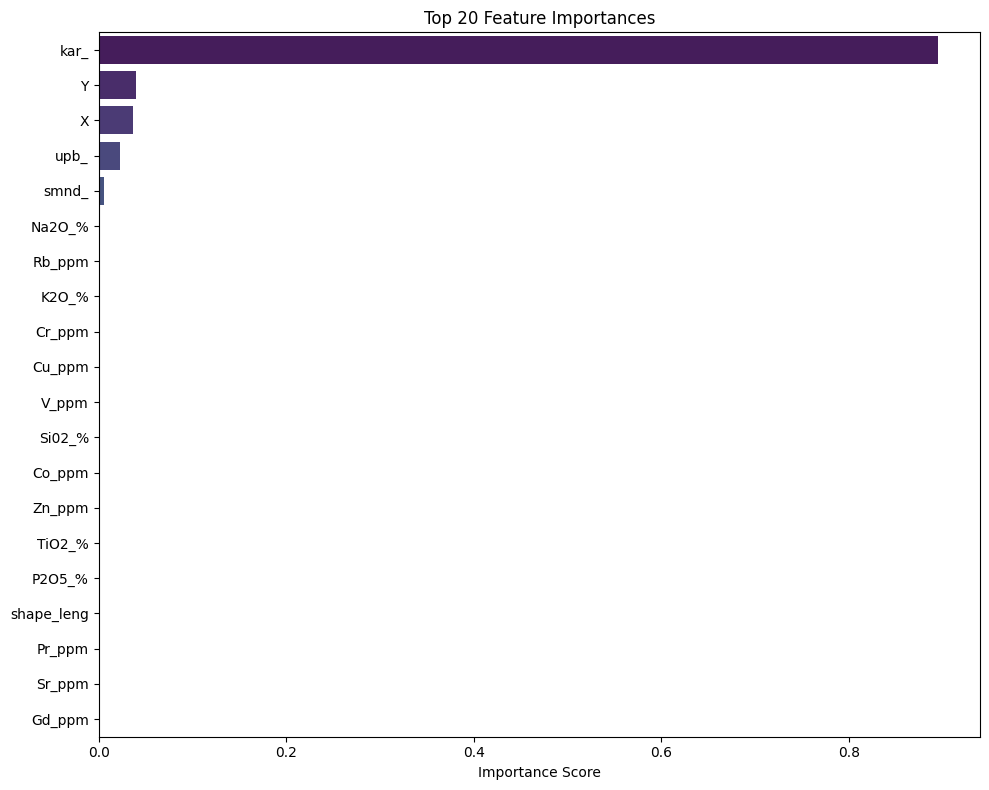

In [25]:

# Step 10: Feature Importance Plot
importances = model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feat_imp[:20], y=feat_imp.index[:20], palette='viridis')
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

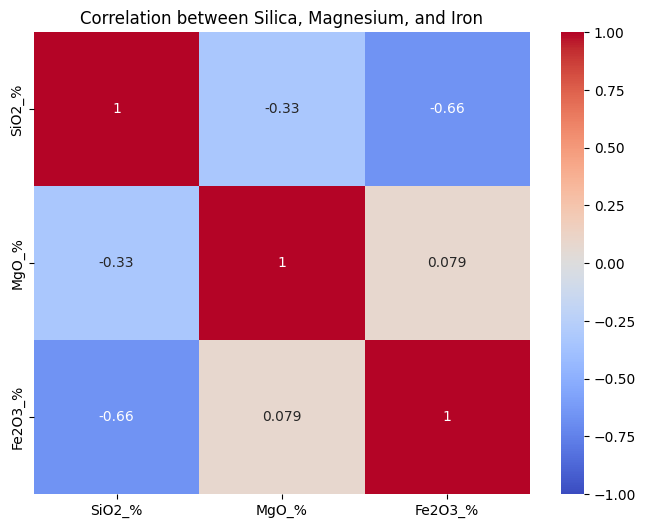

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
data=pd.read_csv("./sedimentary/NGCM-Stream-Sediment-Analysis-Updated.csv")
# Sample data (replace with your geochemical data)
data1 = {
    'SiO2_%': data['Si02_%'].values,
    'MgO_%': data['MgO_%'].values,
    'Fe2O3_%':data['Fe2O3_%'].values 
}

# Create a DataFrame
df = pd.DataFrame(data1)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation between Silica, Magnesium, and Iron')
plt.show()


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#data=pd.read_csv("./sedimentary/NGCM-Stream-Sediment-Analysis-Updated.csv")
data_proper=pd.read_csv("./classificationofminerals/Physical_properties_rock_samples.csv")


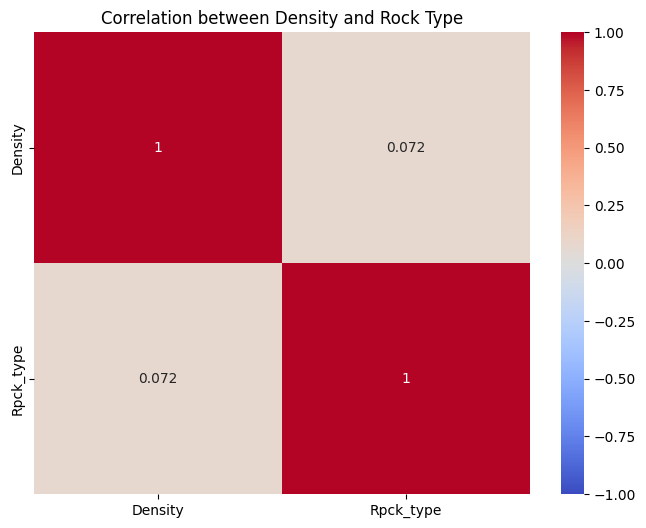

In [28]:

cat_cols = data_proper.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    le = LabelEncoder()
    data_proper['Rock_type'] = le.fit_transform(data_proper['Rock_type'].astype(str))
    label_encoders['Rock_type'] = le  # save the encoder


data1 = {
    'Density': data_proper['Density (g/cc)'].values,
    
    'Rpck_type':data_proper['Rock_type'].values 
}

# Create a DataFrame
df = pd.DataFrame(data1)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation between Density and Rock Type')
plt.show()


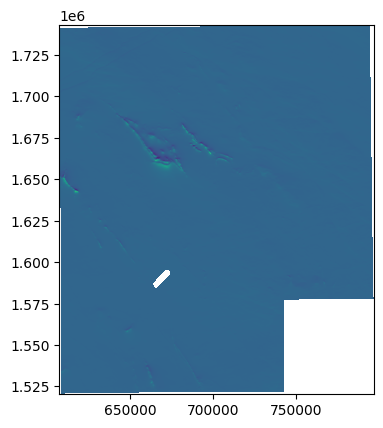

   gid input_cent  edition_no toposheet_ commodity descriptio accession_  \
0   77         SR           1      57B08    Copper       None       None   
1   80         SR           1      57E11   Diamond       None       None   
2   81         SR           1      57E11   Diamond       None       None   
3   82         SR           1      57E11   Diamond       None       None   
4   83         SR           1      57E11   Diamond       None       None   

  remarks                   geometry  
0    None   POINT (76.4441 14.14972)  
1    None  POINT (77.58692 15.28887)  
2    None  POINT (77.59776 15.29494)  
3    None  POINT (77.59186 15.28002)  
4    None  POINT (77.59679 15.28057)  


In [29]:
import rasterio
import geopandas as gpd
from rasterio.plot import show

raster = rasterio.open('./classificationofminerals/Magnet/TAIL_TMI_GE.tiff')
show(raster)
# Load shapefile
minerals = gpd.read_file('./classificationofminerals/Mineralization/mineralization_25k_ngdr_20250224141143411.shp')
print(minerals.head())


In [30]:
import geopandas as gpd
import os
import pandas as pd

# Path to folder with SHP files
folder_path = "./classificationofminerals/Mineralization"

# Read all SHP files
shp_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".shp")]
gdfs = [gpd.read_file(shp) for shp in shp_files]

# Combine into one GeoDataFrame
combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

print(f"Loaded {len(combined_gdf)} features.")


Loaded 17 features.


In [31]:
import geopandas as gpd
import os
import pandas as pd

# Path to folder with SHP files
folder_path = "./classificationofminerals/geochronology"

# Read all SHP files
shp_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".shp")]
gdfs = [gpd.read_file(shp) for shp in shp_files]

# Combine into one GeoDataFrame
combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

print(f"Loaded {len(combined_gdf)} features.")


Loaded 63 features.


In [32]:
comb= combined_gdf[['kar_','smnd_','upb_']]
comb= comb.fillna(0)
comb

,kar_,smnd_,upb_
0,83.0,0.0,0.0
1,87.0,0.0,0.0
2,97.0,0.0,0.0
3,98.0,0.0,0.0
4,101.0,0.0,0.0
...,...,...,...
58,0.0,0.0,164.0
59,0.0,0.0,165.0
60,0.0,0.0,166.0
61,0.0,0.0,169.0


In [33]:
# Convert to DataFrame without geometry
#df = combined_gdf.drop(columns="geometry")

# Optionally drop irrelevant fields (e.g., IDs)
df = comb.select_dtypes(include=["int", "float"])


In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
combined_gdf["cluster"] = kmeans.fit_predict(df)


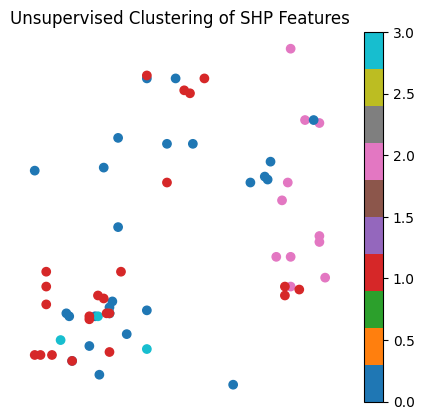

In [35]:
import matplotlib.pyplot as plt

combined_gdf.plot(column="cluster", cmap="tab10", legend=True)
plt.title("Unsupervised Clustering of SHP Features")
plt.axis("off")
plt.show()


In [13]:
# Drop rows without coordinates
df= pd.read_csv("exploration_dataset1.csv")
df.dropna(subset=["X", "Y",'Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
df.columns
df=df[['X', 'Y', 'bouguer_an', 'commodity',
       'CODE_DESC', 'shape_leng', 'Si02_%', 'Al2O3_%', 'Fe2O3_%', 'TiO2_%',
       'CaO_%', 'MgO_%', 'MnO_%', 'Na2O_%', 'K2O_%', 'P2O5_%', 'LOI_%',
       'Ba_ppm', 'Ga_ppm', 'Sc_ppm', 'V_ppm', 'Th_ppm', 'Pb_ppm', 'Ni_ppm',
       'Co_ppm', 'Rb_ppm', 'Sr_ppm', 'Y_ppm', 'Zr_ppm', 'Nb_ppm', 'Cr_ppm',
       'Cu_ppm', 'Zn_ppm', 'Au_ppb', 'Li_ppm', 'Cs_ppm', 'As_ppm', 'Sb_ppm',
       'Bi_ppm', 'Se_ppm', 'Ag_ppb', 'Cd_ppb', 'Hg_ppb', 'Be_ppm', 'Ge_ppm',
       'Mo_ppm', 'Sn_ppm', 'La_ppm', 'Ce_ppm', 'Pr_ppm', 'Nd_ppm', 'Sm_ppm',
       'Eu_ppm', 'Tb_ppm', 'Gd_ppm', 'Dy_ppm', 'Ho_ppm', 'Er_ppm', 'Tm_ppm',
       'Yb_ppm', 'Lu_ppm', 'Hf_ppm', 'Ta_ppm', 'W_ppm', 'U_ppm', 'Pt_ppb',
       'Pd_ppb', 'In_ppm', 'F_ppm', 'Te_ppm', 'Tl_ppm', 'Density (g/cc)',
       'Rock_type', 'Susceptibility(X 10^(-6) CGS units)', 'name', 'fold_type',
       'fault_type', 'kar_', 'smnd_', 'upb_']]


C:\Users\ss529\AppData\Local\Temp\ipykernel_8716\3880727201.py:2: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv("exploration_dataset1.csv")


In [37]:
# Select features for clustering
feature_cols =['Si02_%','Al2O3_%','Fe2O3_%','TiO2_%','kar_','smnd_','upb_']  # Replace with your real column names
features = df[feature_cols].select_dtypes(include=["int", "float"]).dropna()


In [38]:
features

,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,kar_,smnd_,upb_
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
34851,0.0,0.0,0.0,0.0,0.0,0.0,164.0
34852,0.0,0.0,0.0,0.0,0.0,0.0,165.0
34853,0.0,0.0,0.0,0.0,0.0,0.0,166.0
34854,0.0,0.0,0.0,0.0,0.0,0.0,169.0


In [39]:
from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df["cluster"] = kmeans.fit_predict(features)


In [40]:
from sklearn.cluster import DBSCAN

coords = df[["Y", "X"]]
db = DBSCAN(eps=0.01, min_samples=5).fit(coords)
df["spatial_cluster"] = db.labels_


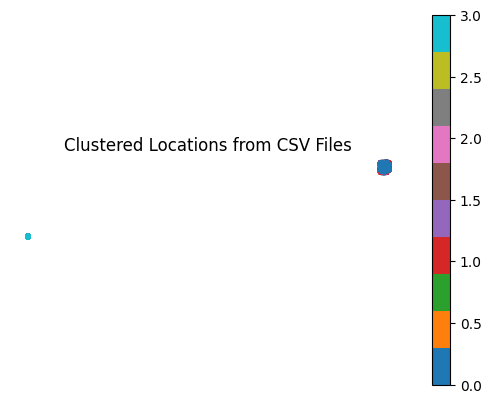

In [41]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Create geometry column
df["geometry"] = df.apply(lambda row: Point(row["X"], row["Y"]), axis=1)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# Plot clusters
gdf.plot(column="cluster", cmap="tab10", legend=True, markersize=10)
plt.title("Clustered Locations from CSV Files")
plt.axis("off")
plt.show()


In [42]:
gdf.to_file("clustered_data.geojson", driver="GeoJSON")


In [43]:
gdf.to_file("clustered_data.shp")


C:\Users\ss529\AppData\Local\Temp\ipykernel_2472\1684082401.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("clustered_data.shp")
C:\Users\ss529\anaconda3\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Density (g/cc)' to 'Density (g'
  ogr_write(
C:\Users\ss529\anaconda3\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Susceptibility(X 10^(-6) CGS units)' to 'Susceptibi'
  ogr_write(
C:\Users\ss529\anaconda3\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'spatial_cluster' to 'spatial_cl'
  ogr_write(


In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import rasterio
from rasterio.transform import from_origin

# Load CSV
df = pd.read_csv("exploration_dataset1.csv")

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(df["X"], df["Y"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Project to a metric CRS (important for consistent pixel size)
gdf = gdf.to_crs("EPSG:3857")

# Extract bounds
minx, miny, maxx, maxy = gdf.total_bounds

# Define raster resolution (in meters)
pixel_size = 100  # adjust based on desired resolution

# Calculate raster size
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Create transform
transform = from_origin(minx, maxy, pixel_size, pixel_size)

# Create empty raster
raster = np.full((height, width), np.nan)

# Fill raster with point values (nearest point mapping)
for _, row in gdf.iterrows():
    col = int((row.geometry.x - minx) / pixel_size)
    row_idx = int((maxy - row.geometry.y) / pixel_size)
    raster[row_idx, col] = row["Value"]

# Write to GeoTIFF
new_dataset = rasterio.open(
    "output.tif",
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="float32",
    crs="EPSG:3857",
    transform=transform,
)

new_dataset.write(raster.astype("float32"), 1)
new_dataset.close()


C:\Users\ss529\AppData\Local\Temp\ipykernel_2472\1718433493.py:9: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("exploration_dataset1.csv")


In [9]:
center_lon = df['X']
center_lat = df['Y']

df["distance_to_center"] = np.sqrt((df["X"] - center_lon)**2 + (df["Y"] - center_lat)**2)


In [57]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le1=LabelEncoder()
le2=LabelEncoder()
le3=LabelEncoder()
le4=LabelEncoder()
df["Rock_type"] = le.fit_transform(df["Rock_type"])
df["commodity"] = le1.fit_transform(df["commodity"])
df["name"]=le2.fit_transform(df["name"])
df["fault_type"]=le3.fit_transform(df["fault_type"])
df["fold_type"]=le3.fit_transform(df["fold_type"])
df["CODE_DESC"]=le4.fit_transform(df["CODE_DESC"])
from sklearn.preprocessing import LabelEncoder


y_encoded = le.fit_transform(y)  # y = original categorical labels (e.g., mineral names)


In [61]:
le.classes_ 


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52], dtype=int64)

In [62]:
le.inverse_transform([0, 1, 2])  


array([0, 1, 2], dtype=int64)

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaled = MinMaxScaler().fit_transform(df)


In [20]:
import numpy as np

def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Earth radius in kilometers
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df["distance_km"] = haversine(df["X"], df["Y"], center_lon, center_lat)


In [23]:
df.to_csv("engineered_features.csv", index=False)



# === ✅ Done ===
print("Feature engineering completed. Output saved.")

Feature engineering completed. Output saved.


In [24]:
df

,X,Y,bouguer_an,commodity,CODE_DESC,shape_leng,Si02_%,Al2O3_%,Fe2O3_%,TiO2_%,...,Density (g/cc),Rock_type,Susceptibility(X 10^(-6) CGS units),name,fold_type,fault_type,kar_,smnd_,upb_,distance_km
0,76.8616,14.2522,-72.0,52,2,0.0,0.0,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,0.0,0.0
1,76.9966,14.2552,-68.0,52,2,0.0,0.0,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,0.0,0.0
2,76.9861,14.2556,-67.0,52,2,0.0,0.0,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,0.0,0.0
3,76.8458,14.2535,-72.0,52,2,0.0,0.0,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,0.0,0.0
4,76.9423,14.2554,-68.0,52,2,0.0,0.0,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,0.0000,0.0000,0.0,52,2,0.0,0.0,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,164.0,0.0
34852,0.0000,0.0000,0.0,52,2,0.0,0.0,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,165.0,0.0
34853,0.0000,0.0000,0.0,52,2,0.0,0.0,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,166.0,0.0
34854,0.0000,0.0000,0.0,52,2,0.0,0.0,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,169.0,0.0


In [25]:
features = df.select_dtypes(include=["int", "float"]).dropna()

In [26]:
from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
df["cluster"] = kmeans.fit_predict(features)


In [27]:
from sklearn.cluster import DBSCAN

coords = df[["Y", "X"]]
db = DBSCAN(eps=0.01, min_samples=5).fit(coords)
df["spatial_cluster"] = db.labels_

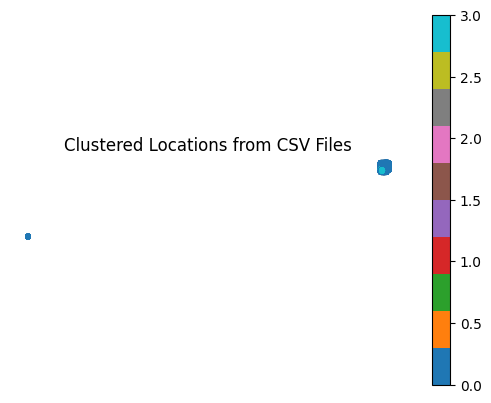

In [28]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Create geometry column
df["geometry"] = df.apply(lambda row: Point(row["X"], row["Y"]), axis=1)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# Plot clusters
gdf.plot(column="cluster", cmap="tab10", legend=True, markersize=10)
plt.title("Clustered Locations from CSV Files")
plt.axis("off")
plt.show()

In [29]:
gdf.to_file("clustered_data.geojson", driver="GeoJSON")


In [30]:
gdf.to_file("clustered_data.shp")


C:\Users\ss529\AppData\Local\Temp\ipykernel_8716\1684082401.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("clustered_data.shp")
C:\Users\ss529\anaconda3\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Density (g/cc)' to 'Density (g'
  ogr_write(
C:\Users\ss529\anaconda3\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Susceptibility(X 10^(-6) CGS units)' to 'Susceptibi'
  ogr_write(
C:\Users\ss529\anaconda3\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'distance_km' to 'distance_k'
  ogr_write(
C:\Users\ss529\anaconda3\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'spatial_cluster' to 'spatial_cl'
  ogr_write(


In [33]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load feature data
data = pd.read_csv("engineered_features.csv")

X = data.drop(columns=["commodity"]).values
y = data["commodity"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

# Model
class MLP(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # for regression; use output size = num_classes for classification_
 )

    def forward(self, x):
        return self.fc(x)

model = MLP(X_train.shape[1])
loss_fn = nn.MSELoss()  # or nn.CrossEntropyLoss() for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    pred = model(X_train).squeeze()
    loss = loss_fn(pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")

Epoch 0 - Loss: 2687.7578
Epoch 10 - Loss: 2601.5022
Epoch 20 - Loss: 2412.0330
Epoch 30 - Loss: 2011.5026
Epoch 40 - Loss: 1393.8807
Epoch 50 - Loss: 805.2917
Epoch 60 - Loss: 350.2439
Epoch 70 - Loss: 95.7930
Epoch 80 - Loss: 103.4568
Epoch 90 - Loss: 83.8082


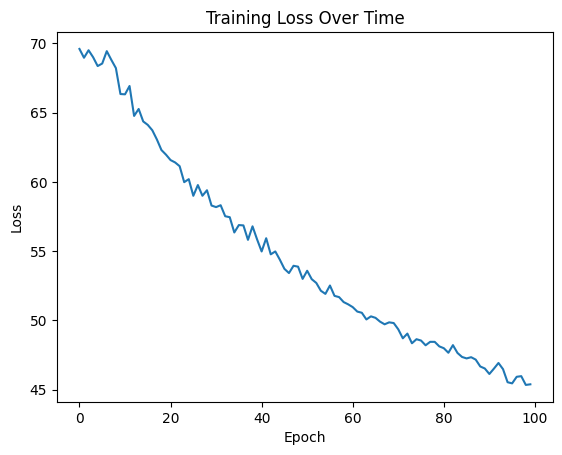

In [34]:
losses = []
for epoch in range(100):
    pred = model(X_train).squeeze()
    loss = loss_fn(pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()


In [35]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)  # for classification

# Model
class MineralClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

num_classes = len(set(y))  # number of unique minerals
model = MineralClassifier(input_size=X.shape[1], num_classes=num_classes)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [36]:
epochs = 100
for epoch in range(epochs):
    model.train()
    pred = model(X_train)
    loss = loss_fn(pred, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")


Epoch 0 - Loss: 15.6987
Epoch 10 - Loss: 0.6321
Epoch 20 - Loss: 0.0932
Epoch 30 - Loss: 0.0702
Epoch 40 - Loss: 0.0641
Epoch 50 - Loss: 0.0553
Epoch 60 - Loss: 0.0496
Epoch 70 - Loss: 0.0449
Epoch 80 - Loss: 0.0425
Epoch 90 - Loss: 0.0398


In [37]:
from sklearn.metrics import accuracy_score

model.eval()
with torch.no_grad():
    pred_probs = model(torch.tensor(X_test, dtype=torch.float32))
    pred_labels = torch.argmax(pred_probs, axis=1).numpy()
    acc = accuracy_score(y_test, pred_labels)
    print(f"Test Accuracy: {acc:.2f}")


Test Accuracy: 0.99


In [56]:
with torch.no_grad():
    outputs = model(X_tensor)
    predicted_class_indices = torch.argmax(outputs, dim=1).numpy()


In [64]:
predicted_class_indices 
predicted_labels = le.inverse_transform(predicted_class_indices)

# Save in your DataFrame
df["predicted_mineral"] = predicted_labels
df

,Unnamed: 0.1,Unnamed: 0,X,Y,bouguer_an,commodity,CODE_DESC,shape_leng,Si02_%,Al2O3_%,...,Density (g/cc),Rock_type,Susceptibility(X 10^(-6) CGS units),name,fold_type,fault_type,kar_,smnd_,upb_,predicted_mineral
0,0,0,76.8616,14.2522,-72.0,52,2,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,0.0,35
1,1,1,76.9966,14.2552,-68.0,52,2,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,0.0,35
2,2,2,76.9861,14.2556,-67.0,52,2,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,0.0,35
3,3,3,76.8458,14.2535,-72.0,52,2,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,0.0,35
4,4,4,76.9423,14.2554,-68.0,52,2,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,0.0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34851,34851,34851,0.0000,0.0000,0.0,52,2,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,164.0,35
34852,34852,34852,0.0000,0.0000,0.0,52,2,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,165.0,35
34853,34853,34853,0.0000,0.0000,0.0,52,2,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,166.0,35
34854,34854,34854,0.0000,0.0000,0.0,52,2,0.0,0.0,0.0,...,0.0,53,0.0,4,5,3,0.0,0.0,169.0,35


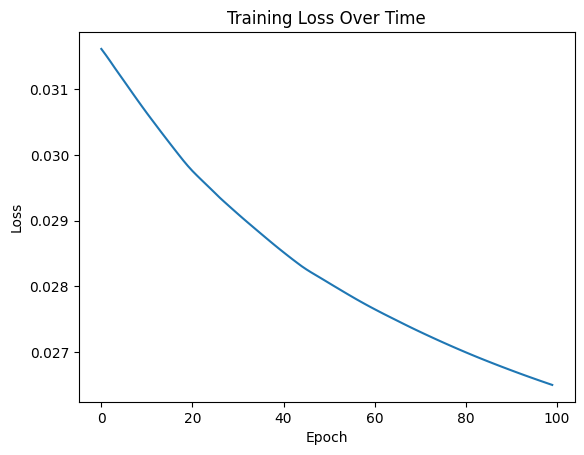

In [38]:
losses = []
for epoch in range(100):
    pred = model(X_train).squeeze()
    loss = loss_fn(pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()